**DEEP REINFORCEMENT LEARNING NANODEGREE - UDACITY**
___

# Deep Q-Network (DQN) mini-project
---
In this notebook, we will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

## Table of content

* [I. Getting acquainted with the Environment](#start-env)
    * [I.1 Examine the State and Action Spaces](#exam-spaces)
    * [I.2 Take Random Actions in the Environment](#random-actions)
* [II. Utilities functions](#utils)    
* [III. Vanilla DQN](#vanilla)
* [IV. Double DQN (DDQN)](#double-dqn)
    * [IV.1 DQN vs. DDQN](#dqn-ddqn)
* [V. Prioritized Experience Replay DQN](#prior-replay)
* [VI. Hyper-parameters tuning](#tuning)

## I. Getting acquainted with the Environment
<a id="getting-acquainted"></a>

* **Import the Necessary Packages**

In [6]:
import gym
!pip3 install box2d
import random
import torch
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt

from dqn_agent import Agent, Vanilla, Double, PrioritizedReplay

plt.style.use('fivethirtyeight')
%matplotlib inline
%load_ext autoreload
%autoreload 2

#!python -m pip install pyvirtualdisplay
#from pyvirtualdisplay import Display
#display = Display(visible=0, size=(1400, 900))
#display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### I.1 Examine state and action spaces
<a id="exam-spaces"></a>

In [13]:
env = gym.make('LunarLander-v2')
env.seed(0)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


Before running the next code cell, familiarize yourself with the code in **Step 2** and **Step 3** of this notebook, along with the code in `dqn_agent.py` and `model.py`.  Once you have an understanding of how the different files work together, 
- Define a neural network architecture in `model.py` that maps states to action values.  This file is mostly empty - it's up to you to define your own deep Q-network!
- Finish the `learn` method in the `Agent` class in `dqn_agent.py`.  The sampled batch of experience tuples is already provided for you; you need only use the local and target Q-networks to compute the loss, before taking a step towards minimizing the loss.

Once you have completed the code in `dqn_agent.py` and `model.py`, run the code cell below.  (_If you end up needing to make multiple changes and get unexpected behavior, please restart the kernel and run the cells from the beginning of the notebook!_)

You can find the solution files, along with saved model weights for a trained agent, in the `solution/` folder.  (_Note that there are many ways to solve this exercise, and the "solution" is just one way of approaching the problem, to yield a trained agent._)

### I.2 Take Random Actions in the Environment
<a id=random-actions></a>

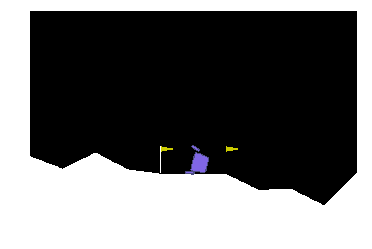

In [4]:
agent = Vanilla(state_size=state_size, action_size=action_size, hidden_layers=[100], seed=0)

# watch an untrained agent
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for j in range(200):
    action = agent.act(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

## II. Utilities functions
<a id=utils></a>

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, 
        priorReplay=False, beta_start=0.4, name="default"):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    beta = lambda episode: min(1.0, beta_start + episode * (1.0 - beta_start) / n_episodes/2)
    
    for i_episode in range(1, n_episodes+1):
    #for i_episode in range(1, 2):
        state = env.reset()        
        score = 0
        for t in range(max_t):
        #for t in range(68):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            if priorReplay: 
                agent.step(state, action, reward, next_state, done, beta(i_episode))
            else:
                agent.step(state, action, reward, next_state, done)
                
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)), end="\n")
            
            checkpoint = {
                'state_size': state_size,
                'action_size': action_size,
                'hidden_layers': [each.out_features for each in agent.qnetwork_local.hidden_layers],
                'state_dict': agent.qnetwork_local.state_dict(),
                'scores': scores}
            
            torch.save(checkpoint, 'checkpoint-' + name + '.pth')                
            break
            
    return scores

In [9]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [10]:
def plot_scores(scores, smooth_window=50):
    scores_smoothed = moving_average(scores, smooth_window)
    # plot the scores
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, linewidth=1, alpha=0.4, color='steelblue')
    plt.plot(np.arange(len(scores))[smooth_window-1:,], scores_smoothed, linewidth=1.5, alpha=1, color='firebrick')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

## III. Vanilla DQN
<a id=vanilla></a>

In [23]:
agent = Vanilla(state_size=state_size, action_size=action_size, hidden_layers=[100], seed=0)
%time scores = dqn(name="vanilla-dqn")

Episode 100	Average Score: -155.72
Episode 200	Average Score: -135.16
Episode 300	Average Score: -133.81
Episode 400	Average Score: -98.805
Episode 500	Average Score: -35.470
Episode 600	Average Score: 60.593
Episode 700	Average Score: 91.95
Episode 800	Average Score: 142.40
Episode 900	Average Score: 155.86
Episode 1000	Average Score: 181.79
Episode 1100	Average Score: 173.39
Episode 1200	Average Score: 157.43
Episode 1300	Average Score: 160.21
Episode 1400	Average Score: 144.12
Episode 1500	Average Score: 146.29
Episode 1600	Average Score: 152.89
Episode 1700	Average Score: 162.36
Episode 1796	Average Score: 128.54

KeyboardInterrupt: 

### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

In [14]:
state = env.reset()

In [15]:
agent = Agent(state_size=state_size, action_size=action_size, hidden_layers=[100], seed=0)

In [16]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, name="default"):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)), end="\n")
            
            checkpoint = {
                'state_size': env.observation_space.shape[0],
                'action_size': env.action_space.n,
                'hidden_layers': [each.out_features for each in agent.qnetwork_local.hidden_layers],
                'state_dict': agent.qnetwork_local.state_dict(),
                'scores': scores}
            
            torch.save(checkpoint, 'checkpoint-' + name + '.pth')                
            break
            
    return scores

Episode 100	Average Score: -164.65
Episode 200	Average Score: -130.52
Episode 300	Average Score: -75.331
Episode 400	Average Score: -42.07
Episode 500	Average Score: 9.1887
Episode 600	Average Score: 60.42
Episode 700	Average Score: 132.07
Episode 800	Average Score: 154.78
Episode 900	Average Score: 101.70
Episode 1000	Average Score: 174.60
Episode 1073	Average Score: 154.04

KeyboardInterrupt: 

NameError: name 'scores' is not defined

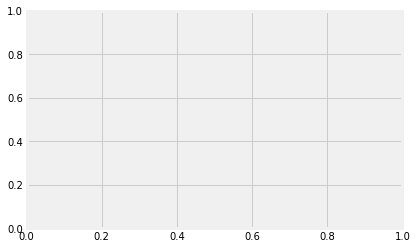

In [17]:
%time scores = dqn(name="vanilla-dqn")

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

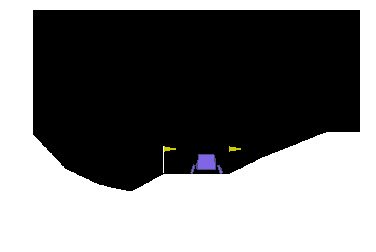

In [7]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(3):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for j in range(200):
        action = agent.act(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

### 5. Explore

In this exercise, you have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task with discrete actions!
- You may like to implement some improvements such as prioritized experience replay, Double DQN, or Dueling DQN! 
- Write a blog post explaining the intuition behind the DQN algorithm and demonstrating how to use it to solve an RL environment of your choosing.  

* **Attempt 1: Vanilla Q-learning**

Environment solved in **1179 episodes** with Average Score: 200.86 in about **30 minutes** (CPU only)